In [1]:
import h5py
import numpy as np
import torch
import torch.utils.data
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
class ModulationDataSets(Dataset):
    def __init__(self, file):
        self.h5 = h5py.File(file, "r")
        self.label_id = self.h5['sampleType']
        _, self.length = self.label_id.shape
        self.img = self.h5['sampleData']
        self.toTensor = ToTensor()

    def __getitem__(self, idx):
        return self.toTensor(self.img[:, :, idx]).float(), torch.tensor(int(self.label_id[0, idx] - 1),
                                                                        dtype=torch.long), torch.tensor(
            int(self.label_id[1, idx]), dtype=torch.long)

    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [3]:
torch.load("basic-8.parm")

OrderedDict([('0.weight',
              tensor([[[[ 0.0285, -0.2760,  0.3852,  0.1578,  0.1084],
                        [ 0.0190,  0.0964,  0.1990, -0.0927,  0.0225],
                        [-0.1057, -0.1137, -0.1086, -0.0352,  0.0172],
                        [-0.0382,  0.1114,  0.2302,  0.0953, -0.0097],
                        [ 0.1674,  0.3382,  0.5162, -0.3214, -0.0452]]],
              
              
                      [[[ 0.6771,  0.3520, -0.0827, -0.0097,  0.0794],
                        [ 0.3298,  0.1763, -0.0379, -0.0740, -0.0631],
                        [ 0.0146,  0.2714, -0.1211, -0.0918, -0.0192],
                        [ 0.3705,  0.2293,  0.0844,  0.0554,  0.0221],
                        [ 0.5340, -0.2067, -0.0503,  0.0697,  0.0049]]],
              
              
                      [[[-0.0527,  0.1443,  0.0313, -0.0840,  0.0066],
                        [-0.0799, -0.0799,  0.0280,  0.0127, -0.0700],
                        [-0.0193, -0.1291, -0.1434,  0.062

In [9]:
net = nn.Sequential(
    # 195-1,64-1
    nn.Conv2d(1, 64, kernel_size=2,stride=1,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
    nn.MaxPool2d((3,2), (3,2)),

    nn.Conv2d(64, 128, 3), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, 3,stride=2,padding=(0,1)), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
    nn.AvgPool2d(2, 2),

    nn.Conv2d(256, 1024, 3,stride=2,padding=(0,1)), nn.BatchNorm2d(1024), nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(1024,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512,8),
    nn.Softmax(dim=0)
)
net.load_state_dict(torch.load("../mod-1.parm"))

<All keys matched successfully>

In [6]:
X = torch.rand(size=(1, 1, 195, 64), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 196, 65])
BatchNorm2d output shape: 	 torch.Size([1, 64, 196, 65])
ReLU output shape: 	 torch.Size([1, 64, 196, 65])
Conv2d output shape: 	 torch.Size([1, 64, 197, 66])
BatchNorm2d output shape: 	 torch.Size([1, 64, 197, 66])
ReLU output shape: 	 torch.Size([1, 64, 197, 66])
MaxPool2d output shape: 	 torch.Size([1, 64, 65, 33])
Conv2d output shape: 	 torch.Size([1, 128, 63, 31])
BatchNorm2d output shape: 	 torch.Size([1, 128, 63, 31])
ReLU output shape: 	 torch.Size([1, 128, 63, 31])
Conv2d output shape: 	 torch.Size([1, 128, 61, 29])
BatchNorm2d output shape: 	 torch.Size([1, 128, 61, 29])
ReLU output shape: 	 torch.Size([1, 128, 61, 29])
MaxPool2d output shape: 	 torch.Size([1, 128, 30, 14])
Conv2d output shape: 	 torch.Size([1, 256, 28, 12])
BatchNorm2d output shape: 	 torch.Size([1, 256, 28, 12])
ReLU output shape: 	 torch.Size([1, 256, 28, 12])
Conv2d output shape: 	 torch.Size([1, 256, 26, 10])
BatchNorm2d output shape: 	 torch.Size([1, 2

In [16]:
train_path = r'E:\test.h5'
test_path = r'E:\train.h5'
train_dataset = ModulationDataSets(train_path)
test_dataset = ModulationDataSets(test_path)
batch_size = 100
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=0, drop_last=False)

## 提取单独类型

In [5]:
name = ['singlepulse', 'freqdiv', 'LFM', 'QFM', '2FSK', '4FSK', 'BPSK', 'QPSK']

In [6]:
path = r"E:\test-large.h5"
h5 = h5py.File(path)
g_label = h5['sampleType'][:]
g_data = h5['sampleData'][:, :, :]
h5.close()
toTensor = ToTensor()

In [14]:
def filter(type=None, snr=None) -> np.ndarray:
    full = (g_label[0, :] != None)
    if (type != None):
        full = full & (g_label[0, :] == type)
    if (snr != None):
        full = full & (g_label[1, :] == snr)
    # 将TrueFalse数组转换为索引
    ids = np.argwhere(full).reshape(-1)
    return ids


def getData(type, snr):
    ids = filter(type, snr).tolist()
    length = len(ids)
    return g_data[:, :, ids], g_label[0, ids].reshape(1, -1)


class TypeSet(Dataset):
    def __init__(self, type, snr):
        self.img, self.label = getData(type, snr)
        _, self.length = self.label.shape

    def __getitem__(self, idx):
        return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.long)

    def __len__(self):
        return self.length


def getLoader(type, snr):
    set = TypeSet(type, snr)
    #print(set.__len__())
    return torch.utils.data.DataLoader(
        dataset=set, batch_size=set.__len__(), shuffle=False,
        num_workers=0, drop_last=False)


x = getLoader(1, -10)

In [12]:
x, y = getData(1, -10)
x.shape, y.shape

((195, 64, 123), (1, 123))

In [15]:
img, label = next(iter(x))
img.shape, label.shape

C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_11420\405424776.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.long)


(torch.Size([123, 1, 195, 64]), torch.Size([123]))

In [38]:
ids = filter(1, 2)
x = g_data[:, :, ids].reshape(196, 64, -1)
type(x), x.shape

(numpy.ndarray, (196, 64, 121))

In [ ]:
getData(1, -10)

In [7]:
output = net(img)
output.shape

E:\App\Miniconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([121, 8])

In [16]:
result = np.ndarray((8, 41))
for n in range(1, 1 + len(name)):
    for snr in range(-10, 31):
        img, labels = next(iter(getLoader(n, snr)))
        length = len(labels)
        output = net(img)
        pred = output.data.max(1, keepdim=True)[1].reshape(length)
        pred = pred.numpy()
        labels = labels.reshape(length).numpy()
        err_idx = np.argwhere(pred != labels)
        accuacy=(length - len(err_idx)) * 100 / length
        print("{}:\t {}dB\t accuracy:{}%".format(name[n - 1], snr, (length - len(err_idx)) * 100 / length))
        result[n-1,snr+10]=accuacy
        #SNR_array.append(snr.tolist()[0])
        #accuracy_array.append(80 - 80 * len(err_idx) / 80)

C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_11420\405424776.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.long)


singlepulse:	 -10dB	 accuracy:3.252032520325203%
singlepulse:	 -9dB	 accuracy:3.389830508474576%
singlepulse:	 -8dB	 accuracy:4.444444444444445%
singlepulse:	 -7dB	 accuracy:16.05839416058394%
singlepulse:	 -6dB	 accuracy:14.84375%
singlepulse:	 -5dB	 accuracy:8.256880733944953%
singlepulse:	 -4dB	 accuracy:8.661417322834646%
singlepulse:	 -3dB	 accuracy:5.825242718446602%
singlepulse:	 -2dB	 accuracy:12.396694214876034%
singlepulse:	 -1dB	 accuracy:11.11111111111111%
singlepulse:	 0dB	 accuracy:12.244897959183673%
singlepulse:	 1dB	 accuracy:8.955223880597014%
singlepulse:	 2dB	 accuracy:12.871287128712872%
singlepulse:	 3dB	 accuracy:10.655737704918034%
singlepulse:	 4dB	 accuracy:10.256410256410257%
singlepulse:	 5dB	 accuracy:13.20754716981132%
singlepulse:	 6dB	 accuracy:10.9375%


KeyboardInterrupt: 

In [65]:
result

array([[ 51.92307692,  63.02521008,  60.15625   ,  75.47169811,
         81.14754098,  84.09090909,  86.33093525,  90.35087719,
         92.68292683,  96.49122807,  99.21875   , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        ],
       [ 92.66055046,  95.76271186,  94.85294118,  94.7826087 ,
         97.87234043,  99.25373134,  96.26168224,  99.20634921,
        100.        ,  96.15384615,  99.19354839,  95.79831933,
         98.31932773,  98.36065574,  97.87234043,  99.04761905,
         99.21259843,  96.875     ,  99.11504425,  98.50746269,
         95.68965

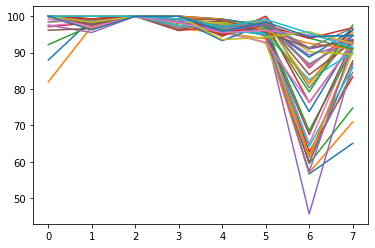

In [57]:
plt.plot(result)

In [17]:
import matplotlib.pyplot as plt

accuacy = []
for img, labels in test_loader:
    #plt.imshow(img[i, 0, :, :].t(), cmap="gray")
    #plt.title('predict:{} real:{}'.format(name[pred[i]], name[labels[i]]))
    #plt.show()
    print('predict:{} real:{}'.format(pred, labels))
    err_idx = np.argwhere(pred != labels)
    accuacy.append(100 - len(err_idx))
plt.plot(accuacy)

NameError: name 'test_loader' is not defined

## 单SNR测试

In [7]:
path = r"E:\test1.h5"
file = h5py.File(path, "r")
file.keys()

<KeysViewHDF5 ['SNRData', 'SNRType']>

In [35]:
file['SNRType']

<HDF5 dataset "SNRType": shape (5, 3280), type "<f8">

In [8]:
file.close()

In [5]:
class SNRDataSets(Dataset):
    def __init__(self, file):
        self.h5 = h5py.File(file, "r")
        self.label_id = self.h5['SNRType']
        _, self.length = self.label_id.shape
        self.img = self.h5['SNRData']
        self.toTensor = ToTensor()

    def __getitem__(self, idx):
        return (self.toTensor(self.img[:, :, idx]).float(),
                torch.tensor(int(self.label_id[0, idx] - 1), dtype=torch.long),
                torch.tensor(self.label_id[1, idx]))

    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [9]:
snr_dataset = SNRDataSets(path)
snr_loader = torch.utils.data.DataLoader(
    dataset=snr_dataset, batch_size=80,
    shuffle=False, num_workers=0, drop_last=False)

In [45]:
img, label, snr = next(iter(snr_loader))

In [46]:
img.shape

torch.Size([80, 1, 196, 64])

In [47]:
label.shape

torch.Size([80])

In [10]:
SNR_array = []
accuracy_array = []
for img, labels, snr in snr_loader:
    length = len(labels)
    output = net(img)
    pred = output.data.max(1, keepdim=True)[1].reshape(length)
    pred = pred.numpy()
    labels = labels.reshape(length).numpy()
    err_idx = np.argwhere(pred != labels)
    # print("SNR:{} accuracy:{}%".format(snr[0],80-80*len(err_idx)/80))
    SNR_array.append(snr.tolist()[0])
    accuracy_array.append((length - len(err_idx)) / length * 100)

E:\App\Miniconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0, 0.5, 'accuracy')

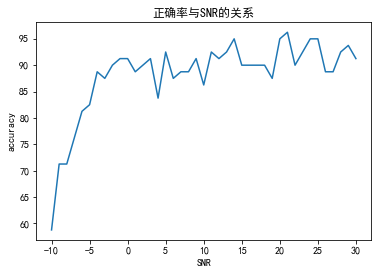

In [12]:
plt.plot(SNR_array, accuracy_array)
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

plt.title("正确率与SNR的关系")
plt.xlabel("SNR")
plt.ylabel("accuracy")